In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from sklearn.model_selection import train_test_split

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-04-18 15:21:43--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-04-18 15:21:43 (4.23 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [6]:
# Target Encoding

# split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# define categorical columns
cat_columns = ['sex', 'smoker', 'region']

# compute means
for col in cat_columns:
    means = train_dataset.groupby(col)['expenses'].mean()
    # map means to categories
    train_dataset[col + '_target'] = train_dataset[col].map(means)
    test_dataset[col + '_target'] = test_dataset[col].map(means)

# drop original categorical columns
train_dataset = train_dataset.drop(cat_columns, axis=1)
test_dataset = test_dataset.drop(cat_columns, axis=1)

# pop labels
train_labels = train_dataset.pop('expenses')
test_labels = test_dataset.pop('expenses')

In [4]:
# create normalization layer
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_dataset))

# build the neural network model
model = keras.Sequential([
    normalizer,
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

# implement early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# train the model
history = model.fit(
    train_dataset,
    train_labels,
    epochs=500,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

9/9 - 0s - 9ms/step - loss: 19376868.0000 - mae: 2634.2698 - mse: 19376868.0000
Testing set Mean Abs Error: 2634.27 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


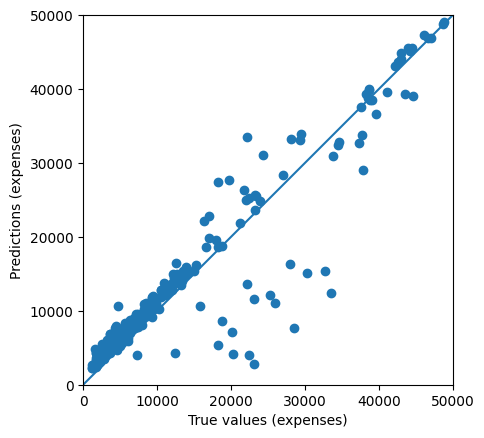

In [5]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)